In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import sklearn.cluster as cl
import TMRF_functions as tmrf
import GMRF_functions as gmrf
import parameter_estimation as pe
import MH_functions as mh
import numpy as np
import cv2

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#Reading of the psf 

my_psf=tmrf.psf_read('PSF GL.tif')
my_psf/=np.linalg.norm(my_psf)
my_psf/=my_psf.sum(axis=(1,2))[0]



In [11]:
#constants

a, P, Q=my_psf.shape
K=2
option=True#if true covariance matrix else it's the variance
#starting parameters for Gaussian field

rho=25
sigma_V=1
q_init =gmrf.get_base_q(rho,sigma_V,P,Q,"gau")
init_V= gmrf.sample_from_fourier(q_init,0,P,Q)
init_V=mh.scaler(init_V,0,a-1)

#iteration parameters

iter_SPE=50
nbr_iter_gibbs=50
step_size=20
n_total=1000
radius=25

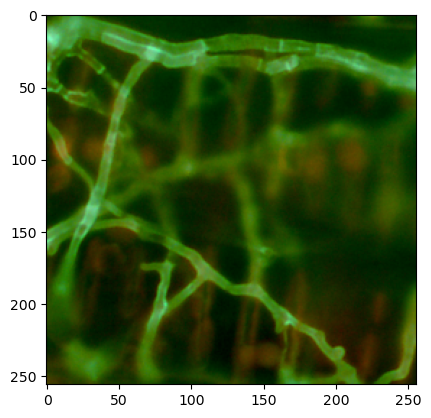

In [12]:
#Reading the image
Y=mpimg.imread('90.png')
Y= cv2.resize(Y, (256,256))
plt.imshow(Y)
plt.show()

In [13]:
#Generation of the starting image
KM = cl.KMeans(n_clusters=2,random_state = 0).fit(Y.reshape(P*Q,3))
X_prec=KM.labels_.reshape(P,Q)  

X_prec_rgb=np.zeros_like(Y)
for c in range(3):
    X_prec_rgb[:,:,c]=X_prec

In [14]:
#segmentation

#estimation of the starting parameters
sigma, mu, alpha=pe.MLE(X_prec, X_prec_rgb, Y, K, P, Q, my_psf, init_V, option)


[[[0.28790855 0.         0.        ]
  [0.         0.28790855 0.        ]
  [0.         0.         0.28790855]]

 [[0.24647972 0.         0.        ]
  [0.         0.24647972 0.        ]
  [0.         0.         0.24647972]]]


In [16]:
#parameter estimation using SPE algorithm
sigma_est, mu_est, alpha_est, V_est = pe.SPE(Y,X_prec,init_V, my_psf,sigma, mu, alpha,
                                                q_init,radius,step_size,n_total,iter_SPE,option)

iteration numéro 1
iteration numéro 2
iteration numéro 3
iteration numéro 4
iteration numéro 5


In [18]:
X_bw_map_t, X_rgb_map_t=tmrf.MAP_segmentation(Y,X_prec,V_est, my_psf,sigma_est, mu_est, alpha_est,
                                         nbr_iter_gibbs, option)


gibbs chromatic stops at 11


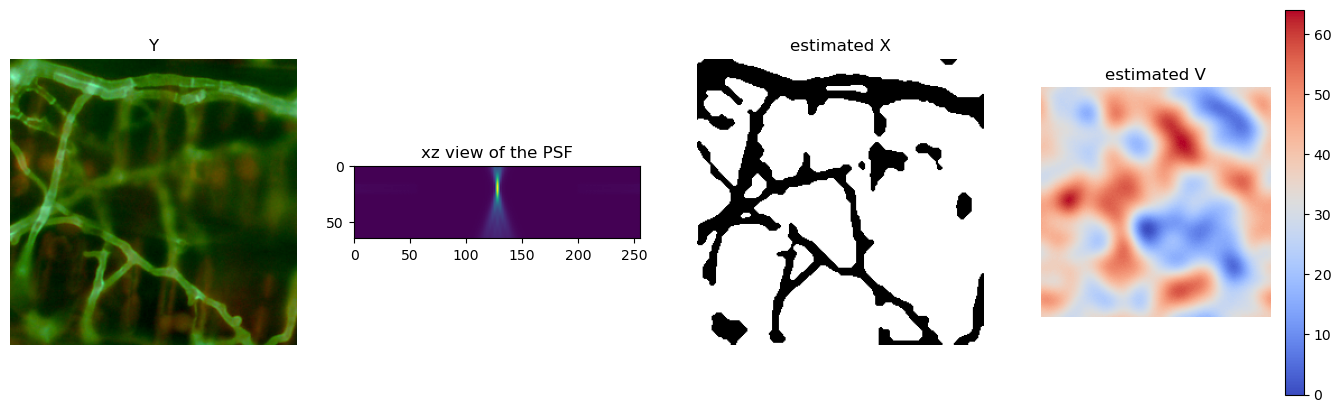

In [19]:
plt.figure(figsize=(17,5))

plt.subplot(1,4,1)
plt.imshow(Y,cmap=plt.cm.coolwarm)
plt.title('Y')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(my_psf.sum(axis=2))
plt.title('xz view of the PSF')

plt.subplot(1,4,3)
plt.imshow(X_bw_map_t,cmap='gray')
plt.title('estimated X')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(V_est,cmap=plt.cm.coolwarm)
plt.title('estimated V')
plt.colorbar()
plt.axis('off')

plt.show()